In [24]:
import pandas as pd
import numpy as np

import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import geopandas
from cartopy.io import shapereader
from cartopy.feature import ShapelyFeature
%matplotlib inline

In [25]:
# load in the point-based data for installed wind capacity
# CEA data can be created using the parse-cea-data notebook
# the satellite dataset is downloaded from Kruitwagen et al (2018)
# the gridded products generated in this script are available on zenodo:
# https://zenodo.org/records/7824872

all_df = pd.read_csv("../../cea-data/parsed-cea-all.csv")
flex_df = pd.read_csv("../../cea-data/parsed_solar-OSM.csv")

In [26]:
state_totals_df = pd.read_csv("../../cea-data/state-totals.csv")

state_list = state_totals_df['state'].values

In [27]:
# extract the wind-related installations and separate into states

cea_solar = all_df.loc[all_df['type'].isin(['Solar',])]
solar_total_by_state = state_totals_df[['state','solar']]

In [28]:
print(solar_total_by_state)

                     state    solar
0      Andaman and Nicobar    12.19
1           Andhra Pradesh  3559.02
2        Arunachal Pradesh     5.61
3                    Assam    41.23
4                    Bihar   149.35
5               Chandigarh    36.99
6             Chhattisgarh   231.35
7   Dadar and Nagar Haveli     5.46
8            Daman and Diu    16.56
9             NCT of Delhi   156.12
10                     Goa     4.78
11                 Gujarat  2763.55
12                 Haryana   249.27
13        Himachal Pradesh    32.57
14       Jammu and Kashmir    19.30
15               Jharkhand    38.40
16               Karnataka  7274.93
17                  Kerala   141.75
18             Lakshwadeep     0.75
19          Madhya Pradesh  2237.49
20             Maharashtra  1663.42
21                 Manipur     4.58
22               Meghalaya     0.12
23                 Mizoram     1.52
24                Nagaland     1.00
25                  Odisha   397.84
26              Puducherry  

In [29]:
cea_grouped = cea_solar.groupby(['state']).sum().reset_index()
flex_grouped = flex_df.groupby(['state']).sum().reset_index()

In [30]:
print(flex_grouped)

                state      id  serial           lon          lat  capacity_MW  \
0      Andhra Pradesh    8256    8132   9659.693252  1881.759687     4038.780   
1   Arunachal Pradesh   70980    1192   2825.865978   826.501324        2.860   
2               Assam    2005       1     93.255130    26.407384        5.000   
3               Bihar   23166      78   1030.878096   307.729014      138.000   
4          Chandigarh   93375    1275   3839.734271  1414.741864       17.795   
5        Chhattisgarh    3654       6    245.521905    64.991208      160.000   
6         Daman & Diu   10668      36    579.153304   163.947586       16.740   
7               Delhi   24687      91   1003.925545   372.415391        2.420   
8             Gujarat  287500   28668  14263.407619  4547.653413     1459.000   
9           Jharkhand   23310      78   1023.068761   281.471771       32.480   
10          Karnataka  203138   73301  28613.974668  5725.738703     5620.060   
11             Kerala    348

In [31]:
# set up a dictionary to collect data in a useable form as we iterate through

best_wind_bc = {'lon':[], 'lat':[], 'capacity':[]}
cea_wind_bc = {'lon':[], 'lat':[], 'capacity':[]}
flex_wind_bc = {'lon':[], 'lat':[], 'capacity':[]}

In [32]:
# iterate through states, adding information about installations to dict and compiling state totals
# we use the state totals later to compare to MNRE reports

for state in state_list:
	actual = solar_total_by_state[solar_total_by_state.state==state]['solar'].values
	cea = cea_grouped[cea_grouped.state==state]['capacity_MW'].values
	flex = flex_grouped[flex_grouped.state==state]['capacity_MW'].values
	
	if actual==0: continue
	
	if len(cea)==0: 
		cea = np.array([0])
	if len(flex)==0:
		flex = np.array([0])
	
	cea_factor = actual/cea
	flex_factor = actual/flex
	
	print(state, cea_factor, flex_factor) #this tells us the ratio between our estimate and official MNRE data
	
	cea_state = cea_solar[cea_solar.state==state]
	cea_wind_bc['lon'].extend(cea_state.lon.values)
	cea_wind_bc['lat'].extend(cea_state.lat.values)
	cea_wind_bc['capacity'].extend(cea_state.capacity_MW.values*cea_factor)
	
	flex_state = flex_df[flex_df.state==state]
	flex_wind_bc['lon'].extend(flex_state.lon.values)
	flex_wind_bc['lat'].extend(flex_state.lat.values)
	flex_wind_bc['capacity'].extend(flex_state.capacity_MW.values)

Andaman and Nicobar [inf] [inf]
Andhra Pradesh [0.89181062] [0.88121165]
Arunachal Pradesh [1.39900249] [1.96153846]
Assam [8.21314741] [8.246]
Bihar [1.08224638] [1.08224638]
Chandigarh [2.34262191] [2.07867378]
Chhattisgarh [1.4459375] [1.4459375]
Dadar and Nagar Haveli [inf] [inf]
Daman and Diu [3.03853211] [inf]
NCT of Delhi [inf] [inf]
Goa [inf] [inf]
Gujarat [1.05323836] [1.89413982]
Haryana [341.46575342] [inf]
Himachal Pradesh [2.17133333] [inf]
Jammu and Kashmir [inf] [inf]
Jharkhand [1.18226601] [1.18226601]
Karnataka [2.14733993] [1.29445771]
Kerala [1.53193559] [1.53193559]
Lakshwadeep [inf] [inf]
Madhya Pradesh [0.91429494] [1.09350152]
Maharashtra [66.5368] [1.74563963]
Manipur [inf] [inf]
Meghalaya [inf] [inf]
Mizoram [0.06816143] [0.06816143]
Nagaland [inf] [inf]
Odisha [1.26298413] [3.78895238]
Puducherry [1.50464227] [1.50464227]
Punjab [1.11569883] [4.5529276]
Rajasthan [1.05736687] [1.58323556]
Sikkim [inf] [inf]
Tamil Nadu [1.25464403] [5.51274738]
Telangana [0.995

/tmp/ipykernel_3120/986210382.py:13: RuntimeWarning: divide by zero encountered in divide
  cea_factor = actual/cea
/tmp/ipykernel_3120/986210382.py:14: RuntimeWarning: divide by zero encountered in divide
  flex_factor = actual/flex


In [33]:
best_wind_bc = pd.DataFrame.from_dict(best_wind_bc)
cea_wind_bc = pd.DataFrame.from_dict(cea_wind_bc)
flex_wind_bc = pd.DataFrame.from_dict(flex_wind_bc)

In [34]:
plt.ioff()

plt.figure(figsize = (12,5))
axes = [plt.subplot(1,3,i, projection=cartopy.crs.PlateCarree()) for i in [1,2,3]]

dx = 1
gridx = np.arange(60,100,dx)
gridy = np.arange(5,40,dx)
p = []

cmap = LinearSegmentedColormap.from_list('cmap',['grey','gold','tab:red'], N=15)

In [35]:
# now iterate through the dicts and convert to gridded data

for ax, df in zip(axes, [cea_wind_bc,]):# flex_wind_bc, best_wind_bc]):
	total_power = np.zeros((len(gridy),len(gridx)))
	lons = df.lon.values
	lats = df.lat.values 
	caps = df.capacity.values
	
	for j in range(len(gridy)):
		ymin = gridy[j]-dx/2.
		ymax = ymin+dx
		
		for i in range(len(gridx)):
			xmin = gridx[i]-dx/2.
			xmax = xmin+dx
			
			ix = np.logical_and.reduce([lons<=xmax,lons>xmin,lats<=ymax,lats>ymin])
			#print(np.sum(ix), xmin, xmax, ymin, ymax)
			total_power[j,i] = np.nansum(caps[ix])
	
	print(total_power.min(), total_power.max())
	np.save("gridded-solar-cap.npy", total_power/1000)
	total_power[total_power<=0]=np.nan
	cs = ax.pcolormesh(gridx,gridy,total_power/1000.,vmin=0,vmax=3,cmap = cmap)

0.0 2809.53661682232


In [36]:
kw_arr = np.load("../../kruitwagen/gridded-capacity.npy")
kw_arr[kw_arr<=0] = np.nan
cs = axes[1].pcolormesh(gridx,gridy,kw_arr,vmin=0,vmax=3,cmap = cmap)

In [37]:
df = pd.read_csv("../../capacity/data/installed_oct22.dat", sep='\t', encoding_errors='ignore')
df['solar_density'] = (111**2)/1000*df['Solar']/df['Area'] 
states_df = geopandas.read_file("../other-files/india_states_lores.zip").drop_duplicates()
merged = states_df.merge(df, how='left', left_on='ST_NM', right_on='State')
merged.plot(ax=axes[2], edgecolor='k', linewidth=0.25, column='solar_density', vmin=0, vmax=3, cmap=cmap)

print(merged)

               ST_NM  ST_ID  ID  \
0    Jammu & Kashmir  IN-JK  JK   
1            Gujarat  IN-GJ  GJ   
2            Gujarat  IN-GJ  GJ   
3            Gujarat  IN-GJ  GJ   
4            Gujarat  IN-GJ  GJ   
..               ...    ...  ..   
117      West Bengal  IN-WB  WB   
118           Odisha  IN-OR  OR   
119        Jharkhand  IN-JH  JH   
120     NCT of Delhi  IN-DL  DL   
121        Telangana  IN-TG  TG   

                                              geometry            State  \
0    POLYGON ((75.88864 32.57603, 75.82023 32.48691...  Jammu & Kashmir   
1                                                 None          Gujarat   
2    POLYGON ((68.55820 23.31375, 68.60457 23.29931...          Gujarat   
3    POLYGON ((68.35847 23.80514, 68.39792 23.78486...          Gujarat   
4    POLYGON ((68.30791 23.82375, 68.32403 23.73403...          Gujarat   
..                                                 ...              ...   
117  POLYGON ((88.75870 27.14800, 88.87676 27.10854...

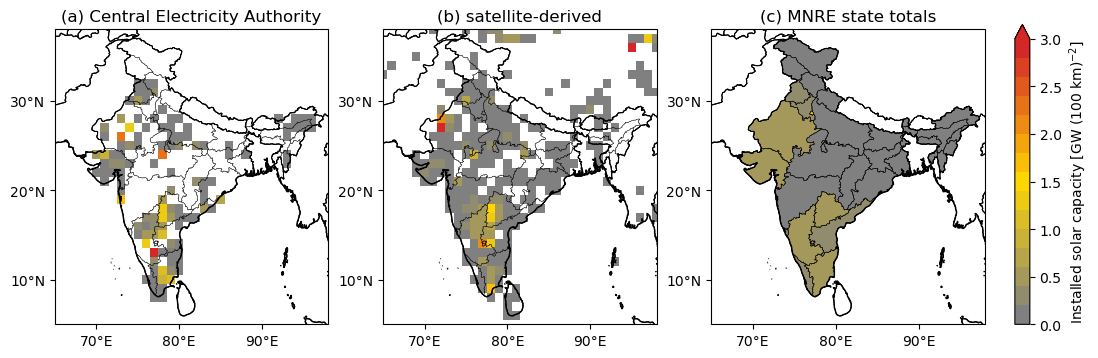

In [38]:
df = geopandas.read_file("../other-files/india_states_lores.zip")
shape_feature = ShapelyFeature(shapereader.Reader("../other-files/ne_10m_admin_0_countries_ind.shp").geometries(),
                                cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', lw=0.75)


for ax in axes:
	ax.coastlines()
	df.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.25)
	ax.add_feature(shape_feature)
	ax.set_xticks(np.arange(0,100,10))
	ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
	ax.set_yticks(np.arange(0,100,10))
	ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
	
	ax.set_xlim([65,98])
	ax.set_ylim([5,38])

axes[0].set_title("(a) Central Electricity Authority")
axes[1].set_title("(b) satellite-derived")
axes[2].set_title("(c) MNRE state totals")


cax = plt.gcf().add_axes([0.925, 0.2, 0.0125, 0.6])
cb = plt.colorbar(cs, cax=cax, orientation='vertical', extend='max')
cb.set_label("Installed solar capacity [GW (100 km)$^{-2}$]")

plt.show()